# 强化学习

强化学习是机器学习领域除有监督学习、无监督学习外的另一个研究分支，它主要利用智能体与环境进行交互，从而学习到能获得良好结果的策略。  
**与有监督学习不同，强化学习的动作并没有明确的标注信息，只有来自环境的反馈的奖励信息，它通常具有一定的滞后性，用于反映动作的“好与坏”。**

## 1.先睹为快

## 1.1 平衡杆游戏
平衡杆游戏系统包含了三个物体：滑轨、小车和杆。如图所示，小车可以自由在滑轨上移动，杆的一侧通过轴承固定在小车上。在初始状态，小车位于滑轨中央，杆竖直立在小车上，智能体通过控制小车的左右移动来控制杆的平衡，当杆与竖直方向的角度大于某个角度或者小车偏离滑轨中心位置一定距离后即视为游戏结束。游戏时间越长，游戏给予的回报也就越多，智能体的操控水平也越高。  
为了简化环境状态的表示，我们这里直接取高层的环境特征向量𝑠作为智能体的输入，它一共包含了四个高层特征，分别为：小车位置、小车速度、杆角度和杆的速度。智能体的输出动作𝑎为向左移动或者向右移动，动作施加在平衡杆系统上会产生一个新的状态，同时系统也会返回一个奖励值，这个奖励值可以简单的记为 1，即时长加一。**在每个时间戳𝑡上面，智能体通过观察环境状态$𝑠_{𝑡}$而产生动作$𝑎_{𝑡}$，环境接收动作后状态改变为$𝑠_{𝑡+1}$，并返回奖励$𝑟_𝑡$。**

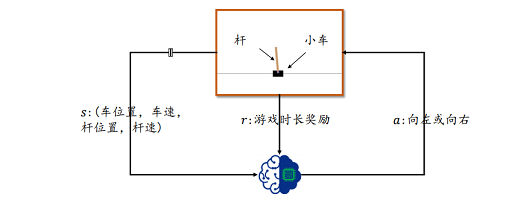

## 1.2 策略网络
如何判断和决策？我们把判断和决策叫作策略(Policy)。策略的输入是状态𝑠，输出为某具体的动作𝑎或动作的分布$𝜋_𝜃(𝑎|𝑠)$，其中𝜃为策略函数𝜋的参数，可以利用神经网络来参数化$𝜋_𝜃$函数，如图所示，图中神经网络$𝜋_𝜃$的输入为平衡杆系统的状态𝑠，即长度为 4 的向量，输出为所有动作的概率$𝜋_𝜃(𝑎|𝑠)$：向左的概率𝑃(向左|𝑠)和向右的概率𝑃(向右|𝑠)，并满足所有动作概率之和为 1 的关系：
$$\sum\limits_{a ~ \in A}𝜋_𝜃(a|s)=1 $$

其中𝐴为所有动作的集合。$𝜋_𝜃$网络代表了智能体的策略，称为策略网络。很自然地，我们可以将策略函数具体化为输入节点为 4 个，中间多个全连接隐藏层，输出层的输出节点数为 2 的神经网络，代表了这两个动作的概率分布。在交互时，选择概率最大的动作：
$$𝑎_𝑡 =\underset{a}{argmax} ~ 𝜋_𝜃(𝑎|𝑠_𝑡)$$
作为决策结果，作用于环境中，并得到新的状态$𝑠_{𝑡+1}$和奖励$𝑟_𝑡$，如此循环往复，直至游戏回合结束.

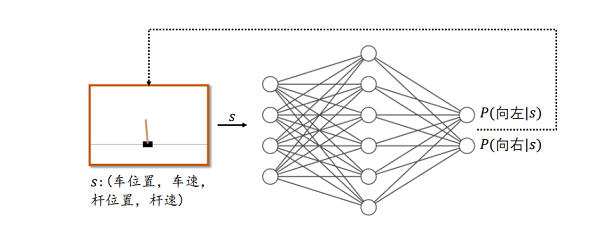

## 1.3 梯度更新
如果需要利用梯度下降算法来优化网络，需要知道每个输入$𝑠_𝑡$的标注信息$𝑎_𝑡$，并且确保从输入到损失值是连续可导的。但是强化学习与传统的有监督学习并不相同，主要体现为**强化学习在每一个时间戳𝑡上面的动作$𝑎_𝑡$并没有一个明确的好与坏的标准**。奖励$𝑟_𝑡$可以在一定程度上反映动作的好坏，但不能直接决定动作的好坏，甚至有些游戏交互过程只有一个最终的代表游戏结果的奖励$𝑟_𝑡$信号.

因此，**策略的优化目标不应该是让输入$𝑠_𝑡$的输出尽可能地逼近标注动作，而是要最大化总回报的期望值**。总回报可以定义为从游戏回合开始到游戏结束前的激励之和$∑𝑟_𝑡$。一个好的策略，应能够在环境上面取得的总的回报的期望值$𝐽(𝜋_𝜃)$最高。

根据梯度上升算法的原理，我们如果能求出$\frac{𝜕𝐽(𝜃)}{𝜕𝜃}$ ，那么策略网络只需要按照
$$𝜃′ = 𝜃 + 𝜂 ∙ \frac{𝜕𝐽(𝜃)}{𝜕𝜃}$$
即可迭代优化策略网络，从而获得较大的期望总回报。  
总回报期望$𝐽(𝜋_𝜃)$是由游戏环境给出的，如果无法得知环境模型，那么$\frac{𝜕𝐽(𝜃)}{𝜕𝜃}$是不能通过自动微分计算的。那么即使$𝐽(𝜋_𝜃)$表达式未知，能不能直接求解偏导数$\frac{𝜕𝐽(𝜃)}{𝜕𝜃}$呢？这个是可以推导出的。
$$\frac{𝜕𝐽(𝜃)}{𝜕𝜃}= 𝔼_{𝜏∼p_{\theta}(𝜏)} [\Big(\sum^T\limits_{t=1} \frac{𝜕}{𝜕𝜃}log ~ 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)\Big)𝑅(𝜏)]$$

利用上式，只需要计算出 $\frac{𝜕}{𝜕𝜃}log ~ 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)$，并乘以$𝑅(𝜏)$即可更新计算出$\frac{𝜕𝐽(𝜃)}{𝜕𝜃}$ ，按照$𝜃′ = 𝜃 −𝜂 ∙\frac{𝜕𝐽(𝜃)}{𝜕𝜃}$ 方式更新策略网络，即可最大化$𝐽(𝜃)$函数。其中$𝑅(𝜏)$为某次交互的总回报，$𝜏$为交互轨迹$𝑠_1, 𝑎_1, 𝑟_1, 𝑠_2, 𝑎_2, 𝑟_2, ⋯ , 𝑠_𝑇$，𝑇是交互的时间戳数量或步数，$log ~ 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)$为策略网络的输出中$𝑎_𝑡$动作的概率值取log函数,$\frac{𝜕}{𝜕𝜃}log ~ 𝜋_𝜃(𝑎_𝑡|𝑠_𝑡)$可以通过 TensorFlow 自动微分求解出网络的梯度，这一部分是连续可导的。

## 2.强化学习问题
在强化学习问题中，具有感知和决策能力的对象叫作智能体(Agent)，它可以是一段算法代码，也可以是具有机械结构的机器人软硬件系统。智能体通过与外界的环境进行交互从而完成某个任务，这里的环境(Environment)是指能受到智能体的动作而产生影响，并给出相应反馈的外界环境的总和。**对于智能体来说，它通过感知环境的状态(State)而产生决策动作(Action)；对于环境来说，它从某个初始初始状态𝑠1开始，通过接受智能体的动作来动态地改变自身状态，并给出相应的奖励(Reward)信号。**   
我们从概率角度描述强化学习过程，它包含了如下 5 个基本对象：  
❑ 状态𝑠 反映了环境的状态特征，在时间戳𝑡上的状态记为$𝑠_𝑡$，它可以是原始的视觉图像、语音波形等信号，也可以是高层抽象过后的特征，如小车的速度、位置等数据，所有的(有限)状态构成了状态空间𝑆  
  
❑ 动作𝑎 是智能体采取的行为，在时间戳𝑡上的状态记为$𝑎_𝑡$，可以是向左、向右等离散动作，也可以是力度、位置等连续动作，所有的(有限)动作构成了动作空间𝐴  
  
❑ 策略𝜋(𝑎|𝑠) 代表了智能体的决策模型，接受输入为状态𝑠，并给出决策后执行动作的概率分布𝑝(𝑎|𝑠)，满足
$$ \sum\limits_{𝑎∈𝐴}𝜋(𝑎|𝑠)= 1$$
这种具有一定随机性的动作概率输出称为随机性策略(Stochastic Policy)。特别地，当策略模型总是输出某个动作的概率为 1，其它为 0 时，这种策略模型称为确定性策略(Deterministic Policy)，即
$$𝑎 = 𝜋(𝑠)$$
❑ 奖励𝑟(𝑠, 𝑎) 表达环境在状态𝑠时接受动作𝑎后给出的反馈信号，一般是一个标量值，它在一定程度上反映了动作的好与坏，在时间戳𝑡上的获得的激励记为$𝑟_{𝑡}$(部分资料上记为$𝑟_{𝑡+1}$，这是因为激励往往具有一定滞后性)  
  
❑ 状态转移概率𝑝(𝑠′|𝑠, 𝑎) 表达了环境模型状态的变化规律，即当前状态𝑠的环境在接受动作𝑎后，状态改变为𝑠′的概率分布，满足  
$$\sum\limits_{𝑠′∈𝑆}𝑝(𝑠′|𝑠, 𝑎)= 1$$

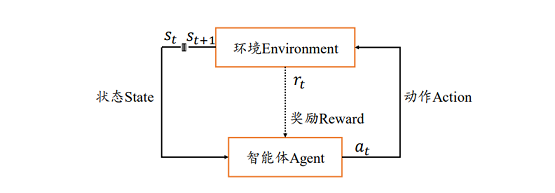

### 2.1 马尔科夫决策过程


智能体从环境的初始状态$𝑠_1$开始，通过策略模型𝜋(𝑎|𝑠)采样某个具体的动作$𝑎_1$执行，环境受到动作$𝑎_1$的影响，状态根据内部状态转移模型𝑝(𝑠′|𝑠, 𝑎)发生改变，变为新的状态$𝑠_2$，同时给出智能体的反馈信号：奖励$𝑟_1$，由奖励函数$𝑟(𝑠_1, 𝑎_1)$产生。如此循环交互，直至达到游戏终止状态$𝑠_𝑇$，这个过程产生了一系列的有序数据：
$$𝜏 = 𝑠_1, 𝑎_1, 𝑟_1, 𝑠_2, 𝑎_2, 𝑟_2, ⋯ , 𝑠_𝑇$$
这个序列代表了智能体与环境的一次交换过程，叫做轨迹(Trajectory)，记为𝜏，一次交互过程叫作一个回合(Episode)，𝑇代表了回合的时间戳数(或步数)。有些环境有明确的终止状态(Terminal State)，比如太空侵略者中的小飞机被击中后则游戏结束；而部分环境没有明确的终止标志，如部分游戏只要保持健康状态，则可以无限玩下去，此时𝑇代表∞。

在状态$𝑠_1, 𝑠_2, \cdots , 𝑠_𝑡$后出现$𝑠_{𝑡+1}$条件概率$𝑃(𝑠_{𝑡+1}|𝑠_1, 𝑠_2,\cdots , 𝑠_𝑡)$是非常重要的，但它需要考虑多个历史状态，计算非常复杂。为了简化，我们假设下一个时间戳上的状态$𝑠_{𝑡+1}$只受当前时间戳$𝑠_𝑡$的影响，而与其它的历史状态$𝑠_1, 𝑠_2, \cdots , 𝑠_{𝑡−1}$无关，即：
$$𝑃(𝑠_{𝑡+1}|𝑠_1, 𝑠_2, \cdots , 𝑠_𝑡)= 𝑃(𝑠_{𝑡+1}|𝑠_𝑡)$$
**这种下一状态$𝑠_{𝑡+1}$只与当前状态$𝑠_𝑡$相关的性质叫做马尔科夫性(Markov Property)**，具有马尔科夫性的序列$𝑠_1, 𝑠_2, \cdots , 𝑠_𝑇$叫做马尔科夫过程(Markov Process)。

如果将执行动作𝑎也考虑进状态转移概率，同样地应用马尔科夫假设：下一个时间戳的状态$𝑠_{𝑡+1}$只与当前的状态$𝑠_𝑡$和当前状态上执行的动作$a_t$相关，则条件概率：
$$𝑃(𝑠_{𝑡+1}|𝑠_1,a_1,\cdots, 𝑠_𝑡,a_t)= 𝑃(𝑠_{𝑡+1}|𝑠_𝑡,a_t)$$

我们把状态和动作的有序序列$𝑠_1,a_1, . . . , 𝑠_𝑇$叫做马尔科夫决策过程(Markov Decision Process，简称 MDP)。有些场景中智能体只能观察到环境的部分状态，称为部分可观察马尔可夫决策过程(Partially Observable Markov Decision Process，简称 POMDP)。尽管马尔科夫性假设并不一定符合实际情况，但却是强化学习中大量理论推导的基石.

现在我们考虑某个轨迹：
$$𝜏= 𝑠_1, 𝑎_1, 𝑟_1, 𝑠_2, 𝑎_2, 𝑟_2, ⋯ , 𝑠_T$$

发生轨迹𝜏的概率P(𝜏):  
$𝑃(𝜏) = 𝑃(𝑠_1, 𝑎_1, 𝑠_2, 𝑎_2,⋯ , 𝑠_𝑇)= 𝑃(𝑠_1)𝜋(𝑎_1|𝑠_1)𝑃(𝑠_2|𝑠_1, 𝑎_1)𝜋(𝑎_2|𝑠_2)𝑃(𝑠_3|𝑠_1, 𝑎_1, 𝑠_2, 𝑎_2) ⋯$  
$ ~ ~ ~ ~ ~ ~ = 𝑃(𝑠_1)∏^{T-1}\limits_{t=1}𝜋(𝑎_𝑡|𝑠_𝑡)𝑝(𝑠_{𝑡+1}|𝑠_1, 𝑎_1, … , 𝑠_𝑡, 𝑎_𝑡)$

应用马尔科夫性后，我们将上述表达式简化为：
$$𝑃(𝜏) = 𝑃(𝑠_1)∏^{T-1}\limits_{t=1}𝜋(𝑎_𝑡|𝑠_𝑡)𝑝(𝑠_{𝑡+1}|𝑠_𝑡, 𝑎_𝑡)$$

马尔科夫决策过程示意图如图所示。  

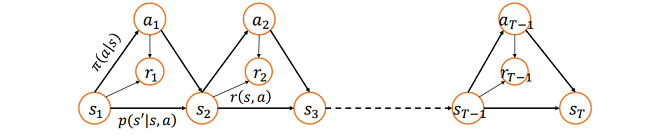

如果能够获得环境的状态转移概率𝑝(𝑠′|𝑠, 𝑎)和激励函数𝑟(𝑠, 𝑎)，可以直接迭代计算值函数，这种已知环境模型的方法统称为基于模型的强化学习(Model-based Reinforcement Learning)。然而现实世界中的环境模型大都是复杂且未知的，这类模型未知的方法统称为模型无关的强化学习(Model-free Reinforcement Learning).

### 2.2 目标函数
在每次智能体与环境的交互过程中，均会得到一个(滞后的)激励信号：
$$𝑟_𝑡 = 𝑟(𝑠_𝑡, 𝑎_𝑡)$$
一次交互轨迹𝜏的累积奖励叫做总回报(Return):
$$𝑅(𝜏)=\sum^{T-1}\limits_{t=1} r_t$$
其中𝑇为轨迹的步数。如果只考虑从轨迹的中间状态$𝑠_𝑡$开始$𝑠_𝑡, 𝑠_{𝑡+1},\cdots, 𝑠_𝑇$的累积回报，可以记为： 
$$𝑅(s_t)=\sum^{T-t-1}\limits_{k=0} r_{t+k}$$

有些环境的激励信号是非常稀疏的，如围棋，前面的下子动作的激励均为 0，只有游戏结束时才有代表输赢的激励信号。
因此，为了权衡近期奖励与长期奖励的重要性，更多地使用随着时间衰减的折扣回报(Discounted Return):
$$𝑅(𝜏)=\sum^{T-1}\limits_{t=1} \gamma^{t-1}r_t=r_1+\gamma r_2+\gamma^2 r_3+\cdots+\gamma^{T-2}r_{T-1}$$

其中𝛾 ∈ [0,1]叫做折扣率。可以看到，近期的激励$𝑟_1$全部用于总回报，而远期的激励$𝑟_{𝑇−1}$则衰减$𝛾^{𝑇−2}$后才能用于贡献总回报$𝑅(𝜏)$。当𝛾 ≈ 1时，短期激励和长期激励权值近似相同，算法更具有远瞻性；当𝛾 ≈ 0时，靠后的长期激励衰减后接近于 0，短期激励变得更重要，算法更具有近视性。**对于没有终止状态的环境，即$𝑇 = ∞$，折扣回报变得非常重要，因为$\sum^{∞}\limits_{𝑡=1}𝛾^{𝑡−1}𝑟_𝑡$可能趋于无穷大，而折扣回报可以近似忽略远期的激励，从而方便算法实现。**  
我们**希望找到一个策略$𝜋(𝑎|𝑠)$模型，使得在策略$𝜋(𝑎|𝑠)$控制下的智能体与环境交互产生的轨迹𝜏的总回报𝑅(𝜏)越高越好。** 由于环境状态转移和策略都具有随机性，同样的策略模型作用于同初始状态的同一环境，也可能产生截然不同的轨迹序列𝜏。因此，强化学习的目标是最大化期望回报(Expected Return)：
$$𝐽(𝜋_𝜃) = 𝔼_{𝜏∼𝑝(𝜏)}[𝑅(𝜏)] = 𝔼_{𝜏∼𝑝(𝜏)} [\sum^{T-1}\limits_{𝑡=1}𝛾^{𝑡−1}𝑟_𝑡]$$
训练的目标是寻找一组参数𝜃代表的策略网络$𝜋_𝜃$，使得$𝐽(𝜋_𝜃)$最大：
$$𝜃^∗ = \underset{𝜃}{argmax} ~ 𝔼_{𝜏∼𝑝(𝜏)}[𝑅(𝜏)]$$
其中**𝑝(𝜏)代表了轨迹𝜏的分布，它由状态转移概率$𝑝(𝑠′|𝑠, 𝑎)$和策略$𝜋(𝑎|𝑠)$共同决定**。策略𝜋的好坏可以通过$𝐽(𝜋_𝜃)$衡量，期望回报越大，策略越优良；反之则策略越差。

### 3. 策略梯度方法
$$𝐽(𝜋_𝜃) = 𝔼_{𝜏∼𝑝(𝜏)}[𝑅(𝜏)]$$
既然强化学习的目标是找到某个最优策略$𝜋_𝜃(𝑎|𝑠)$使得期望回报$𝐽(𝜃)$最大，这类优化问题和有监督学习类似，需要求解期望回报对网络参数$𝜃$的偏导数$\frac{𝜕𝐽}{𝜕𝜃}$，并采用梯度上升算法更新网络参数：
$$𝜃′ = 𝜃 + 𝜂 ∙\frac{𝜕𝐽}{𝜕𝜃}$$
即可，其中𝜂为学习率。  
策略模型$𝜋_𝜃(𝑎|𝑠)$可以采用多层神经网络参数化$𝜋_𝜃(𝑎|𝑠)$，网络的输入为状态𝑠，输出为动作𝑎的概率分布，这种网络称为策略网络。

要优化此网络，只需要求得每个参数的偏导数$\frac{𝜕𝐽}{𝜕𝜃}$即可，现在我们来推导$\frac{𝜕𝐽}{𝜕𝜃}$的表达式。首先按**轨迹分布**展开:  
$\frac{𝜕𝐽}{𝜕𝜃} = \frac{𝜕}{𝜕𝜃} \int 𝑝(𝜏)𝑅(𝜏)d𝜏$  
$ ~ ~ ~ ~ ~ = \int \Big(\frac{𝜕}{𝜕𝜃}𝑝(𝜏)\Big)𝑅(𝜏)d𝜏$  
$ ~ ~ ~ ~ ~ = \int 𝑝(𝜏) ~\frac{1}{𝑝(𝜏)} \Big(\frac{𝜕}{𝜕𝜃}𝑝(𝜏)\Big)𝑅(𝜏)d𝜏$  
$ ~ ~ ~ ~ ~ = \int 𝑝(𝜏)\Big(\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)\Big)𝑅(𝜏)d𝜏$  

即：
$$\frac{𝜕𝐽}{𝜕𝜃}=𝔼_{𝜏∼𝑝(𝜏)}[\Big(\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)\Big)𝑅(𝜏)]$$

其中$log ~ 𝑝(𝜏)$代表了轨迹$𝜏 = 𝑠_1, 𝑎_1, 𝑠_2, 𝑎_2,⋯ , 𝑠_𝑇$的概率值再取log。考虑到$𝑅(𝜏)$可由采样得到，因此$\frac{𝜕𝐽}{𝜕𝜃}$的关键变为求解$ \frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)$，我们分解$𝑝(𝜏)$可得：  

$\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)=\frac{𝜕}{𝜕𝜃}log\Big(𝑃(𝑠_1)∏^{T-1}\limits_{t=1}𝜋_\theta(𝑎_𝑡|𝑠_𝑡)𝑝(𝑠_{𝑡+1}|𝑠_𝑡, 𝑎_𝑡)\Big)$  
$~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  ~ ~ ~ =\frac{𝜕}{𝜕𝜃}\Big( log ~ 𝑃(𝑠_1)+\sum^{T-1}\limits_{t=1}[log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)+log ~ 𝑝(𝑠_{𝑡+1}|𝑠_𝑡, 𝑎_𝑡)]\Big)$

考虑到$log ~ 𝑝(𝑠_{𝑡+1}|𝑠_𝑡, 𝑎_𝑡)、log ~ 𝑝(𝑠_1)$均与𝜃无关，因此上式可变为：  
$$\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)=\frac{𝜕}{𝜕𝜃}\sum^{T-1}\limits_{t=1}log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)$$

可以看到，$\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)$偏导数最终可以转换为策略网络的输出$log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)$对网络参数$𝜃$的偏导数$ \frac{𝜕}{𝜕𝜃}log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)$上，与状态概率转移$𝑝(𝑠′|𝑠, 𝑎)$无关，即不需要知道环境模型也可以求解 $\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)$.

则
$$\frac{𝜕𝐽(\theta)}{𝜕𝜃}=𝔼_{𝜏∼𝑝(𝜏)}[\Big(\frac{𝜕}{𝜕𝜃}\sum^{T-1}\limits_{t=1}log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)\Big)𝑅(𝜏)]$$

当某个回合的总回报𝑅(𝜏) > 0时，$\frac{𝜕𝐽(\theta)}{𝜕𝜃}$与$\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)$同向，因此根据梯度上升算法更新𝜃参数时，既是朝着𝐽(𝜃)增大的方向更新，也是朝着$log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)$增大的方向更新，即鼓励产生更多的这样的轨迹𝜏。当某个回合的总回报𝑅(𝜏) < 0时，$\frac{𝜕𝐽(\theta)}{𝜕𝜃}$ 与$\frac{𝜕}{𝜕𝜃}log ~ 𝑝(𝜏)$反向，因此根据梯度上升算法更新𝜃参数时，既是朝着𝐽(𝜃)增大的方向更新，也是朝着$log ~ 𝜋_\theta(𝑎_𝑡|𝑠_𝑡)$减少的方向更新，即避免产生更多的这样的轨迹𝜏。

### 3.1 REINFORCE 算法

根据大数法则，将期望形式写成多条$𝜏^𝑛$, $𝑛 ∈ [1, 𝑁]$采样轨迹的均值：
$$\frac{𝜕𝐽(\theta)}{𝜕𝜃}\approx \frac{1}{N}\sum^N\limits_{n=1}[\Big(\frac{𝜕}{𝜕𝜃}\sum^{T-1}\limits_{t=1}log ~ 𝜋_\theta(𝑎_𝑡^{(n)}|𝑠_𝑡^{(n)})\Big)𝑅(𝜏^{(n)})]$$

其中𝑁为轨迹数量，$𝑎_𝑡^{(𝑛)}$和$𝑠_𝑡^{(𝑛)}$分布代表第𝑛条轨迹$𝜏^{(𝑛)}$的第𝑡个时间戳的执行的动作和输入状态。再通过梯度上升算法训练更新𝜃参数。这种算法称为 **REINFORCE 算法**.

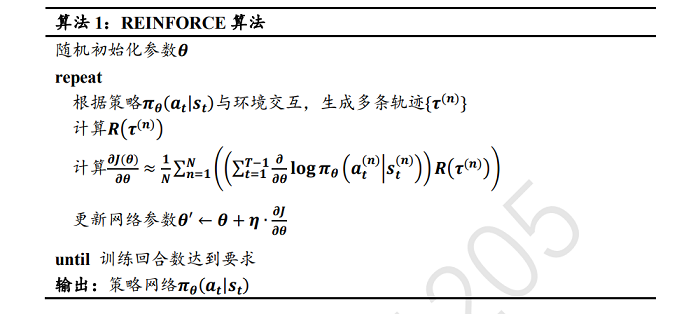